# Cats and dogs with linear regression

In [1]:
import numpy as np
from numpy.random import random, permutation
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import math

Using TensorFlow backend.


In [2]:
%matplotlib inline

# Loading the VGG pretrained network

Vgg is a the 2014 winner of the [imagenet](http://image-net.org/) challenge for image classification. It's been designed to select one of 1000 tags (classes) for each image. 

The way VGG (and most classification networks work) is that it takes the input (an image in this case) and turns it into a vector of "probabilities" for each possible class. After that we can take the class with the highes probability and assign that class to the image as our prediction. 

Here we will use VGG a bit differently. Instead of finding the most probable class, we will simply use the 1000 dimensional probability vector as an input for our own linear clasifyer. 

Let's start by rebuilding VGG in Keras, and loading the weights. **At this point do not bother about undestading the code bellow, we will get back to it later**

In [3]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

def ConvBlock(model, layers, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
model = Sequential()
model.add(Lambda(vgg_preprocess, input_shape=(224,224,3)))
ConvBlock(model, 2, 64)
ConvBlock(model, 2, 128)
ConvBlock(model, 3, 256)
ConvBlock(model, 3, 512)
ConvBlock(model, 3, 512)

model.add(Flatten())
FCBlock(model)
FCBlock(model)
model.add(Dense(1000, activation='softmax'))

model.load_weights('/data/trained_models/vgg16_tf.h5')

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

Finally we will load the class names for VGG so that we can try how it works

In [4]:
import json 
with open('/data/trained_models/imagenet_class_index.json') as f:
    class_dict = json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

# Trying VGG

Let's see a few examples of how VGG is predicting labels. First we need to create a data generator that will load batches of images from the disk.


In [5]:
image_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/cats_vs_dogs/train', 
    target_size=(224,224),
    class_mode=None, 
    shuffle=True, 
    batch_size=8
)

Found 23000 images belonging to 2 classes.


Next we define a plot function for convenience. (You don't need to understand this code either)

In [6]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, sub_titles=None, grayscale=False, cmap=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3 and not grayscale):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=14)
        if sub_titles is not None:
            sp.set_title(titles[i] + " (" + sub_titles[i] + ")", fontsize=14)
        plt.imshow(ims[i], interpolation=None if interp else 'none', cmap=cmap)

Let's grab a batch of images, calculate the class probabilites and finally take the most probable class as a label for each image

In [7]:
imgs = next(image_batches)
preds = model.predict(imgs)
labels = np.vectorize(lambda x: classes[x])(np.argmax(preds, axis=1))

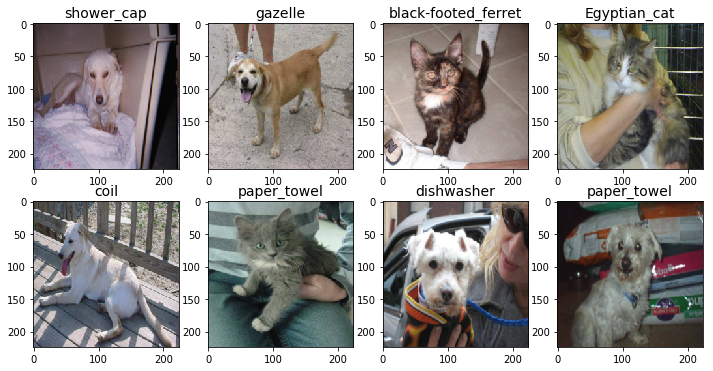

In [8]:
plots(imgs, titles=labels, rows=2)

Depending on the images you might see some pretty accurate predictions, or some aweful ones, but neither of them says dog or cat, which we would need. On the other hand we have a lot more information than just a tag, we have a vector of class probabilities. Let's visualize each as 40x25 pixel heat map:

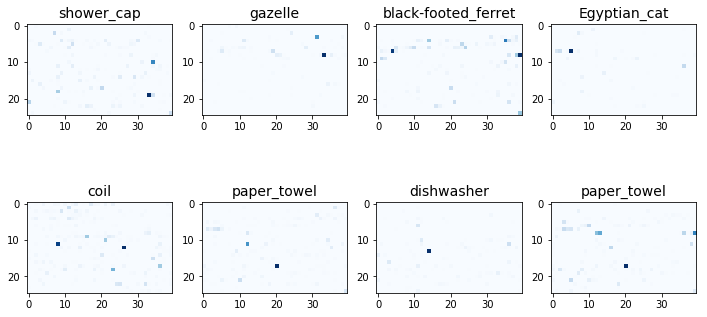

In [9]:
pred_maps = [preds[i].reshape(25,40)/np.amax(preds[i])*255 for i in range(len(preds))]
plots(pred_maps, titles=labels, rows=2, grayscale=True, cmap=plt.cm.Blues)

In some cases that also means that we might have a few other classes that are almost as likely as the one that was predicted. When the first class is incorrect the correct label might still be in the top 5.

In [10]:
top_classes = [
    [
        [
            classes[preds[j].argsort()[-5:][4-i]],
            preds[j][preds[j].argsort()[-5:][4-i]]
        ]  for i in range(5)
    ] for j in range(8)
]
for i, example in enumerate(top_classes):
    for cls in example:
        print(cls[0] + " "*(30-len(cls[0])) + str(cls[1]))
    print("")

shower_cap                    0.135254
bath_towel                    0.0903642
plastic_bag                   0.0465003
swab                          0.0401114
paper_towel                   0.035419

gazelle                       0.276147
Chihuahua                     0.163167
meerkat                       0.0575196
Italian_greyhound             0.0365329
Egyptian_cat                  0.0340005

black-footed_ferret           0.105648
Siamese_cat                   0.101516
Boston_bull                   0.0752609
toilet_tissue                 0.0416656
Norwegian_elkhound            0.0391099

Egyptian_cat                  0.341546
carousel                      0.0874589
tiger_cat                     0.0763466
tabby                         0.0546462
African_grey                  0.039779

coil                          0.106888
birdhouse                     0.100108
prison                        0.0509161
picket_fence                  0.0393494
proboscis_monkey              0.0391958

paper

# Building a linear model on top of VGG

As the next step we will use the class probability vector as an input for our simple linear model. To do that we first need to run the training and validation sets through the VGG model and save the resulting data.

## Pre-calculating VGG results

Let's create the image generators for the train and validation batches. The code bellow is an example of how one would go about doing that. For the actuall pre calculation take a look at vgg_preprocess.py.

In [11]:
def precalc_batches(source, target):
    export_batches = image.ImageDataGenerator().flow_from_directory(
        source,
        target_size=(224,224),
        class_mode='binary', 
        shuffle=False, 
        batch_size=16
    )
    
    batch_count = math.ceil(export_batches.samples/export_batches.batch_size)
    
    with open(target,'w') as f:
        for i in tqdm(range(batch_count)):
            export_imgs,labels = export_batches.next()
            preds = model.predict(export_imgs)
            for i in range(len(labels)):
                json.dump([int(labels[i]), preds[i].tolist()], f)        
                f.write('\n')

In [12]:
precalc_batches('/data/cats_vs_dogs/train', '/data/cats_vs_dogs/precalculated_vgg_train.data')
precalc_batches('/data/cats_vs_dogs/valid', '/data/cats_vs_dogs/precalculated_vgg_valid.data')

Found 23000 images belonging to 2 classes.


  0%|          | 0/125 [00:00<?, ?it/s]

Found 2000 images belonging to 2 classes.


100%|██████████| 125/125 [00:24<00:00,  5.05it/s]


# Loading the VGG results

First we load the pre calculated VGG results

In [13]:
def load(type):
    features = []
    labels = []
    with open('/data/cats_vs_dogs/precalculated_vgg_'+type+'.data','r') as f:
        for l in f:
            d = json.loads(l)
            features.append(d[1])
            labels.append(d[0])
    return np.array(features), np.array(labels)

train_features, train_labels = load('train')
valid_features, valid_labels = load('valid')

Let's build a very simple linear classification modell. It will contain a single dense layer (the equivalent of a single matrix multiplication followed by a sigmoid actiavation), and we will use categorical crossentropy as our loss function. 

The sigmoid function is defined by:

$$S(x) = \frac{1}{1 + e^{-x}}$$

Binary cross entropy is defined by: 

$$-\frac{1}{n} \sum_{t} r_t \ln p_t + (1-r_t)ln(1-p_t)$$

Where $t$ is running over the $n$ training examples, $r_t$ is the expected value for that example, and $p_t$ is the prediction provided by the neural network. 

This setup is perfect when we have two possible options and we want to learn how to tell the two options appart. 

In [14]:
linear_model = Sequential()
linear_model.add(Dense(20, input_shape=(1000,), activation='relu'))
linear_model.add(Dense(1, activation='sigmoid'))
linear_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

We used the Adam optimizer, which will try to decrease our loss function by changing the weight matrices. Let's train the modell on our training data.

In [15]:
linear_model.optimizer.lr=0.001

In [16]:
linear_model.fit(train_features, train_labels, 
                 epochs=40, 
                 batch_size=64, 
                 validation_data=(valid_features, valid_labels), 
                 shuffle=True
                )

Train on 23000 samples, validate on 2000 samples
Epoch 1/40
23000/23000 [==============================] - ETA: 0s - loss: 0.5559 - acc: 0.7933 - val_loss: 0.4392 - val_acc: 0.8185
Epoch 2/40
23000/23000 [==============================] - ETA: 0s - loss: 0.4076 - acc: 0.8250 - val_loss: 0.3932 - val_acc: 0.8265
Epoch 3/40
23000/23000 [==============================] - ETA: 0s - loss: 0.3801 - acc: 0.8323 - val_loss: 0.3796 - val_acc: 0.8350
Epoch 4/40
23000/23000 [==============================] - ETA: 0s - loss: 0.3676 - acc: 0.8366 - val_loss: 0.3724 - val_acc: 0.8390
Epoch 5/40
23000/23000 [==============================] - ETA: 0s - loss: 0.3594 - acc: 0.8418 - val_loss: 0.3693 - val_acc: 0.8355
Epoch 6/40
23000/23000 [==============================] - ETA: 0s - loss: 0.3532 - acc: 0.8447 - val_loss: 0.3682 - val_acc: 0.8385
Epoch 7/40
23000/23000 [==============================] - ETA: 0s - loss: 0.3487 - acc: 0.8477 - val_loss: 0.3658 - val_acc: 0.8385
Epoch 8/40
23000/23000 [===

Now let's look at a few random examples to see how well we are doing.

In [17]:
# imgs = next(image_batches)

In [18]:
intermediate_result = model.predict(imgs)
dog_cat_result = linear_model.predict(intermediate_result).flatten()
dog_cat_labels = np.vectorize(lambda x: ['dog','cat'][1-int(round(x))])(dog_cat_result)
original_labels = np.vectorize(lambda x: classes[x])(np.argmax(intermediate_result, axis=1))

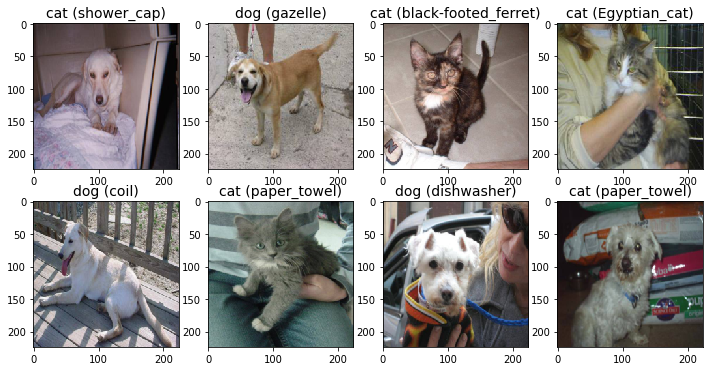

In [19]:
plots(imgs, titles=dog_cat_labels, sub_titles=original_labels, rows=2)

# Confusion matrix

In [20]:
preds = linear_model.predict_classes(valid_features)[:,0]
probs = linear_model.predict_proba(valid_features)[:,0]

2000/2000 [==============================] - ETA: 0s


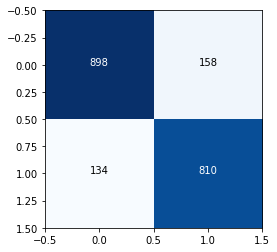

In [21]:
cm = confusion_matrix(preds,valid_labels)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

# A few more examples

It's a good idea to see where our model is most certain about it's decisions, and where it is relatively uncertain.

In [22]:
filenames = image.ImageDataGenerator().flow_from_directory(
    '/data/cats_vs_dogs/valid', 
    target_size=(224,224),
    class_mode='binary', 
    shuffle=False, 
).filenames

Found 2000 images belonging to 2 classes.


In [23]:
def plots_idx(idx, titles=None, rows=1):
    plots([image.load_img('/data/cats_vs_dogs/valid/' + filenames[i]) for i in idx], titles=titles, rows=rows)

## Random correctly labelled

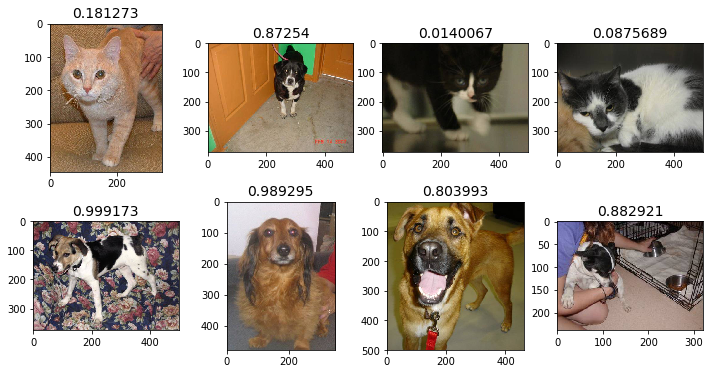

In [24]:
correct = np.where(preds==valid_labels)[0]
correct_idx = permutation(correct)[:8]
plots_idx(correct_idx, titles=probs[correct_idx], rows=2)

## Random incorrectly labeled

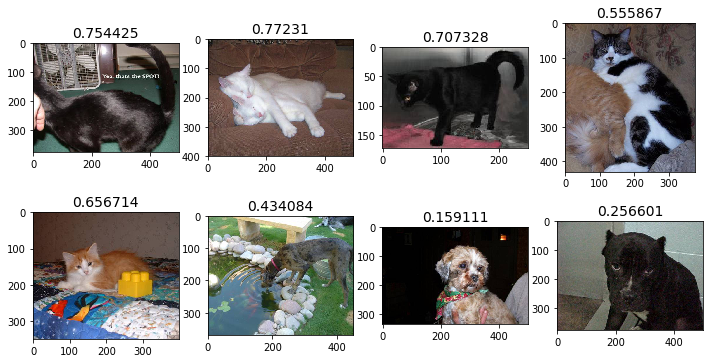

In [25]:
incorrect_idx = permutation(np.where(preds!=valid_labels)[0])[:8]
plots_idx(incorrect_idx, titles=probs[incorrect_idx], rows=2)

## Most confident about correct answer

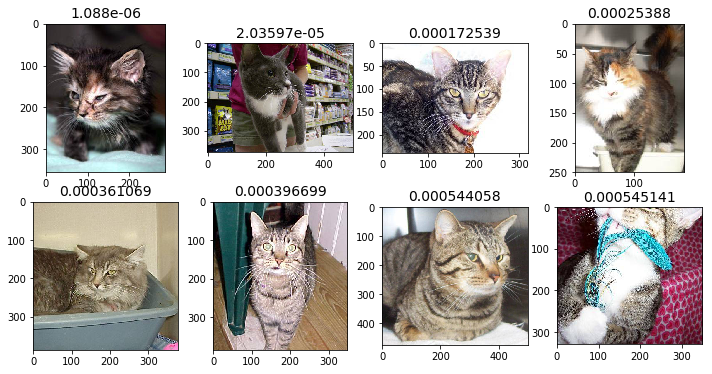

In [26]:
correct_cats = np.where((preds==0) & (preds==valid_labels))[0]
most_correct_cats = np.argsort(probs[correct_cats])[:8]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats], rows=2)

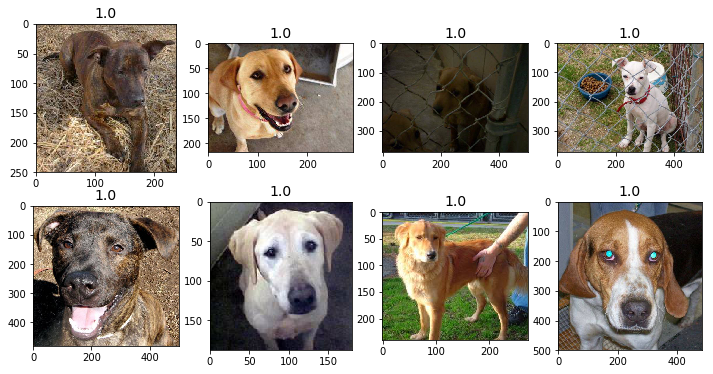

In [27]:
correct_dogs = np.where((preds==1) & (preds==valid_labels))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[::-1][:8]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs], rows=2)

## Most confident wrong answer

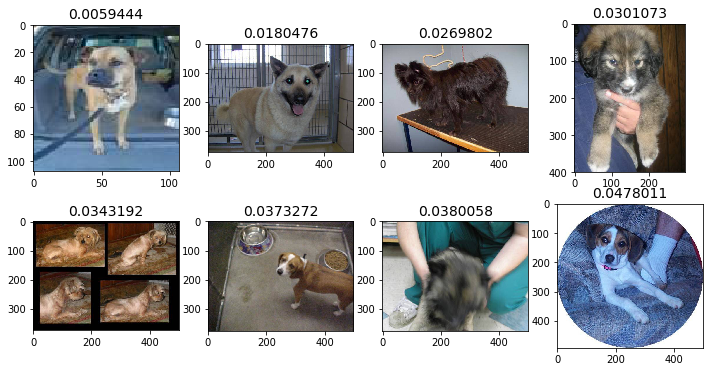

In [28]:
incorrect_cats = np.where((preds==0) & (preds!=valid_labels))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[:8]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats], rows=2)

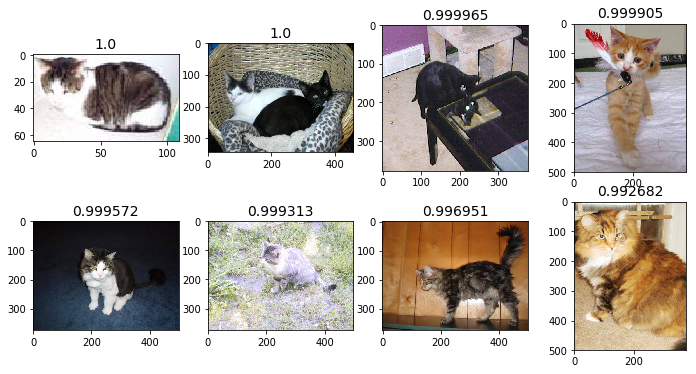

In [29]:
incorrect_dogs = np.where((preds==1) & (preds!=valid_labels))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[::-1][:8]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs], rows=2)

## Most uncertain

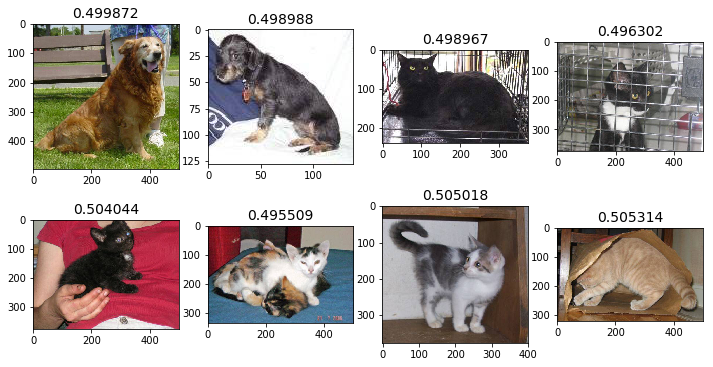

In [30]:
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:8], probs[most_uncertain], rows=2)